# Exploratory Data Analysis

This notebook will perform exploratory data analysis (EDA) of the training and test data. 

This will cover:
- Table summaries 
- Null counts
- Summary statistics and distributional plots for numeric features
- Comparison of features between training and test data
- Histograms for categorical features
- Time series plots to inspect seasonal relationships of weather
- Target column distribution
- Analysis of correlations between the features and the label, including time lag correlation analysis
- Exploration of raw feature predictive power using basic RandomForestClassifier and logistic regression models


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
local_repo_path = r'C:\Users\ChrisSchon\Documents\GitHub\DengAI'
raw_data_path = local_repo_path + r'\data\raw'
processed_data_path = local_repo_path + '\data\processed'

Setup...

In [3]:
train = pd.read_csv(processed_data_path + r'\train_dataset.csv', index_col = 0)
test = pd.read_csv(raw_data_path + r'\dengue_features_test.csv', index_col = None)
combined = pd.read_csv(processed_data_path + r'combined_train_test_dataset.csv', index_col = 0)

In [4]:
#cm = sns.light_palette("green", as_cmap=True)
#train.style.background_gradient(cmap=cm)

In [5]:
#cm = sns.light_palette("orange", as_cmap=True)
#test.style.background_gradient(cmap = cm)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1455
Data columns (total 25 columns):
city                                     1456 non-null object
year                                     1456 non-null int64
weekofyear                               1456 non-null int64
week_start_date                          1456 non-null object
ndvi_ne                                  1262 non-null float64
ndvi_nw                                  1404 non-null float64
ndvi_se                                  1434 non-null float64
ndvi_sw                                  1434 non-null float64
precipitation_amt_mm                     1443 non-null float64
reanalysis_air_temp_k                    1446 non-null float64
reanalysis_avg_temp_k                    1446 non-null float64
reanalysis_dew_point_temp_k              1446 non-null float64
reanalysis_max_air_temp_k                1446 non-null float64
reanalysis_min_air_temp_k                1446 non-null float64
reanalysis_precip

**Features are a mostly numeric. City and year/week of year can be considered as categorical with week_start_date a datetime. Output is a numeric variable (integer number of total disease cases)**

In [7]:
null_counts = pd.DataFrame([(len(train) - train.count())/len(train), (len(test) - test.count())/len(test)]).transpose().reset_index()
null_counts.rename({'index': 'Column',0:'Train', 1:'Test'}, axis = 1, inplace = True)
null_counts = pd.melt(null_counts,id_vars = ['Column'], value_vars=['Train', 'Test']).rename({'variable':'Dataset'}, axis = 1)

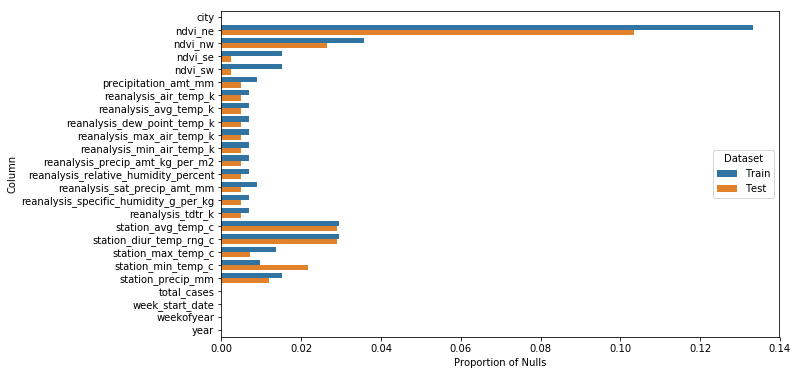

In [8]:
fig, ax = plt.subplots(figsize = (10,6))
sns.barplot(x = 'value', y = 'Column', hue = 'Dataset', data = null_counts, orient = 'h', ax = ax)
plt.xlabel('Proportion of Nulls');

**Null counts are similarly distributed across test and training classes. The only feature with a significant number of nulls is ndvi_ne. The rate justifies experimenting with null imputation in the feature engineering steps**

In [9]:
numeric_cols = combined.select_dtypes(include=[np.number]).drop(['year', 'weekofyear'], axis = 1).columns

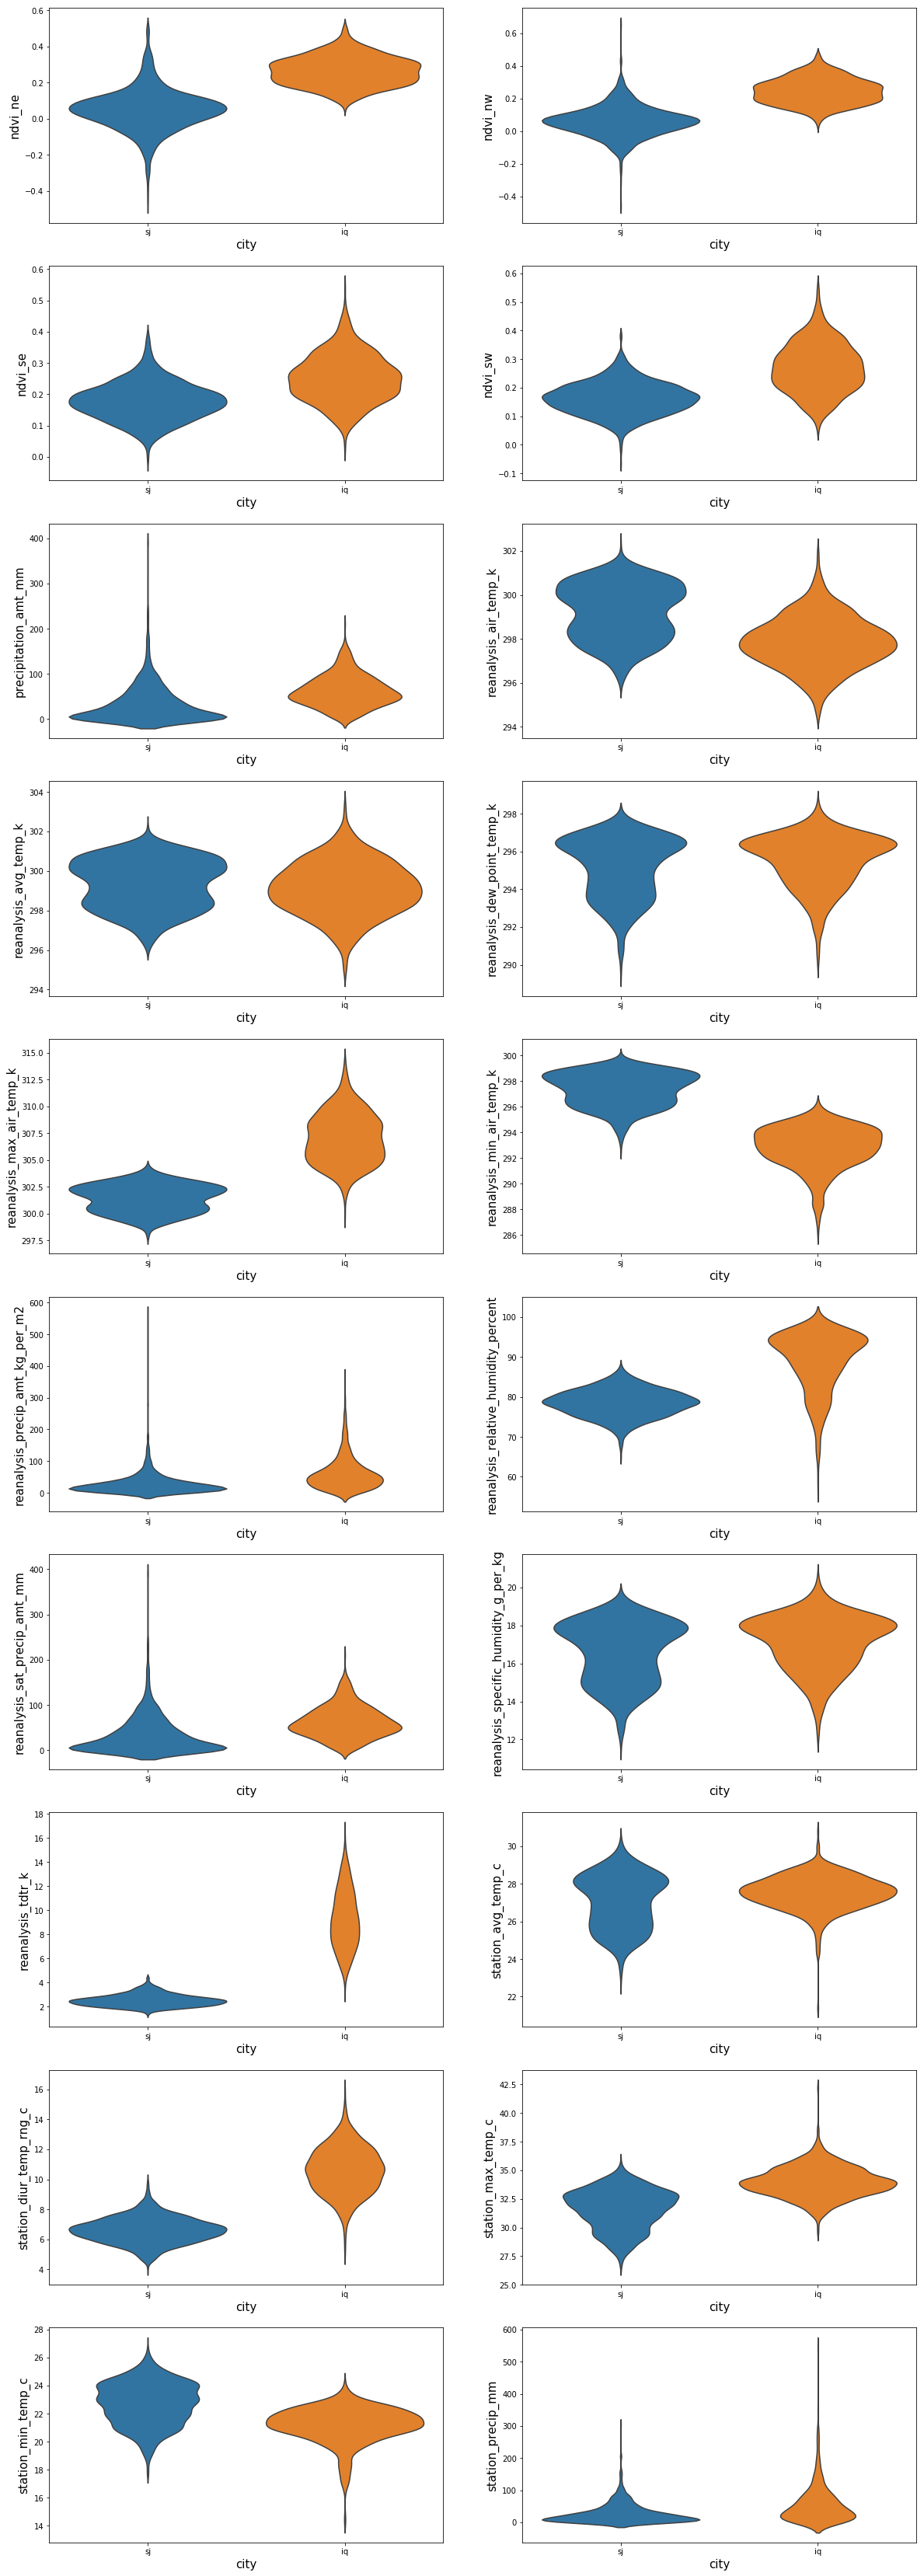

In [10]:
fix, ax = plt.subplots(nrows = 10, ncols = 2, figsize = (20,60))
for i, j in enumerate(numeric_cols):
    sns.violinplot(x = 'city', y = j, data = combined, inner = None, ax = ax[int(np.floor(i/2)),np.mod(i,2)])
    ax[int(np.floor(i/2)),np.mod(i,2)].yaxis.label.set_size(15)
    ax[int(np.floor(i/2)),np.mod(i,2)].xaxis.label.set_size(15)

**There are 20 numerical measurement features found in the data, each representing a weather measurement in city 'sj' or 'iq' in a certain week. There are some differences to be found between the cities. For example, reanalysis_max_air_temp_k appears to not have the same distribution of measurements. It would take some contextual knowledge of the measurements to confirm that however, i.e. is the average measure of 307.5 vs. 301 a significant climate difference indication?**

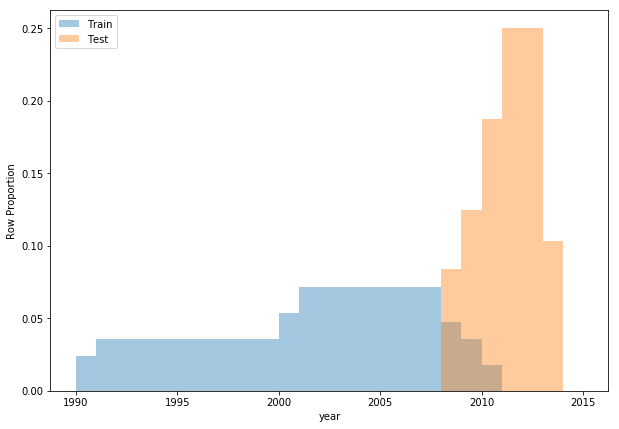

In [11]:
fig, ax = plt.subplots(figsize = (10,7))
sns.distplot(combined['year'][combined['dataset'] == 'train'], kde = False, label = 'Train', bins = np.arange(1990, 2016), norm_hist = True)
sns.distplot(combined['year'][combined['dataset'] == 'test'], kde = False, label = 'Test', bins = np.arange(1990,2016), norm_hist = True)
plt.legend();
plt.ylabel('Row Proportion');

** Measurements are taken during different periods of time between the test and training datasets. The range of time the training data samples from spans over 20 years between 1990 and 2011, whereast test data measurements are 2008-2014. **

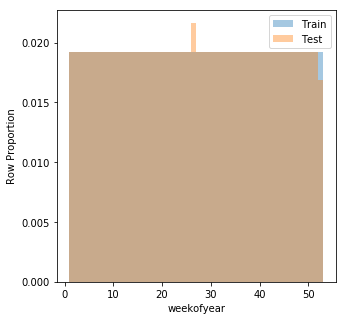

In [12]:
fig, ax = plt.subplots(figsize = (5,5))
sns.distplot(combined['weekofyear'][combined['dataset'] == 'train'], kde = False, label = 'Train', bins = np.arange(1, 54), norm_hist = True)
sns.distplot(combined['weekofyear'][combined['dataset'] == 'test'], kde = False, label = 'Test', bins = np.arange(1,54), norm_hist = True)
plt.legend();
plt.ylabel('Row Proportion');

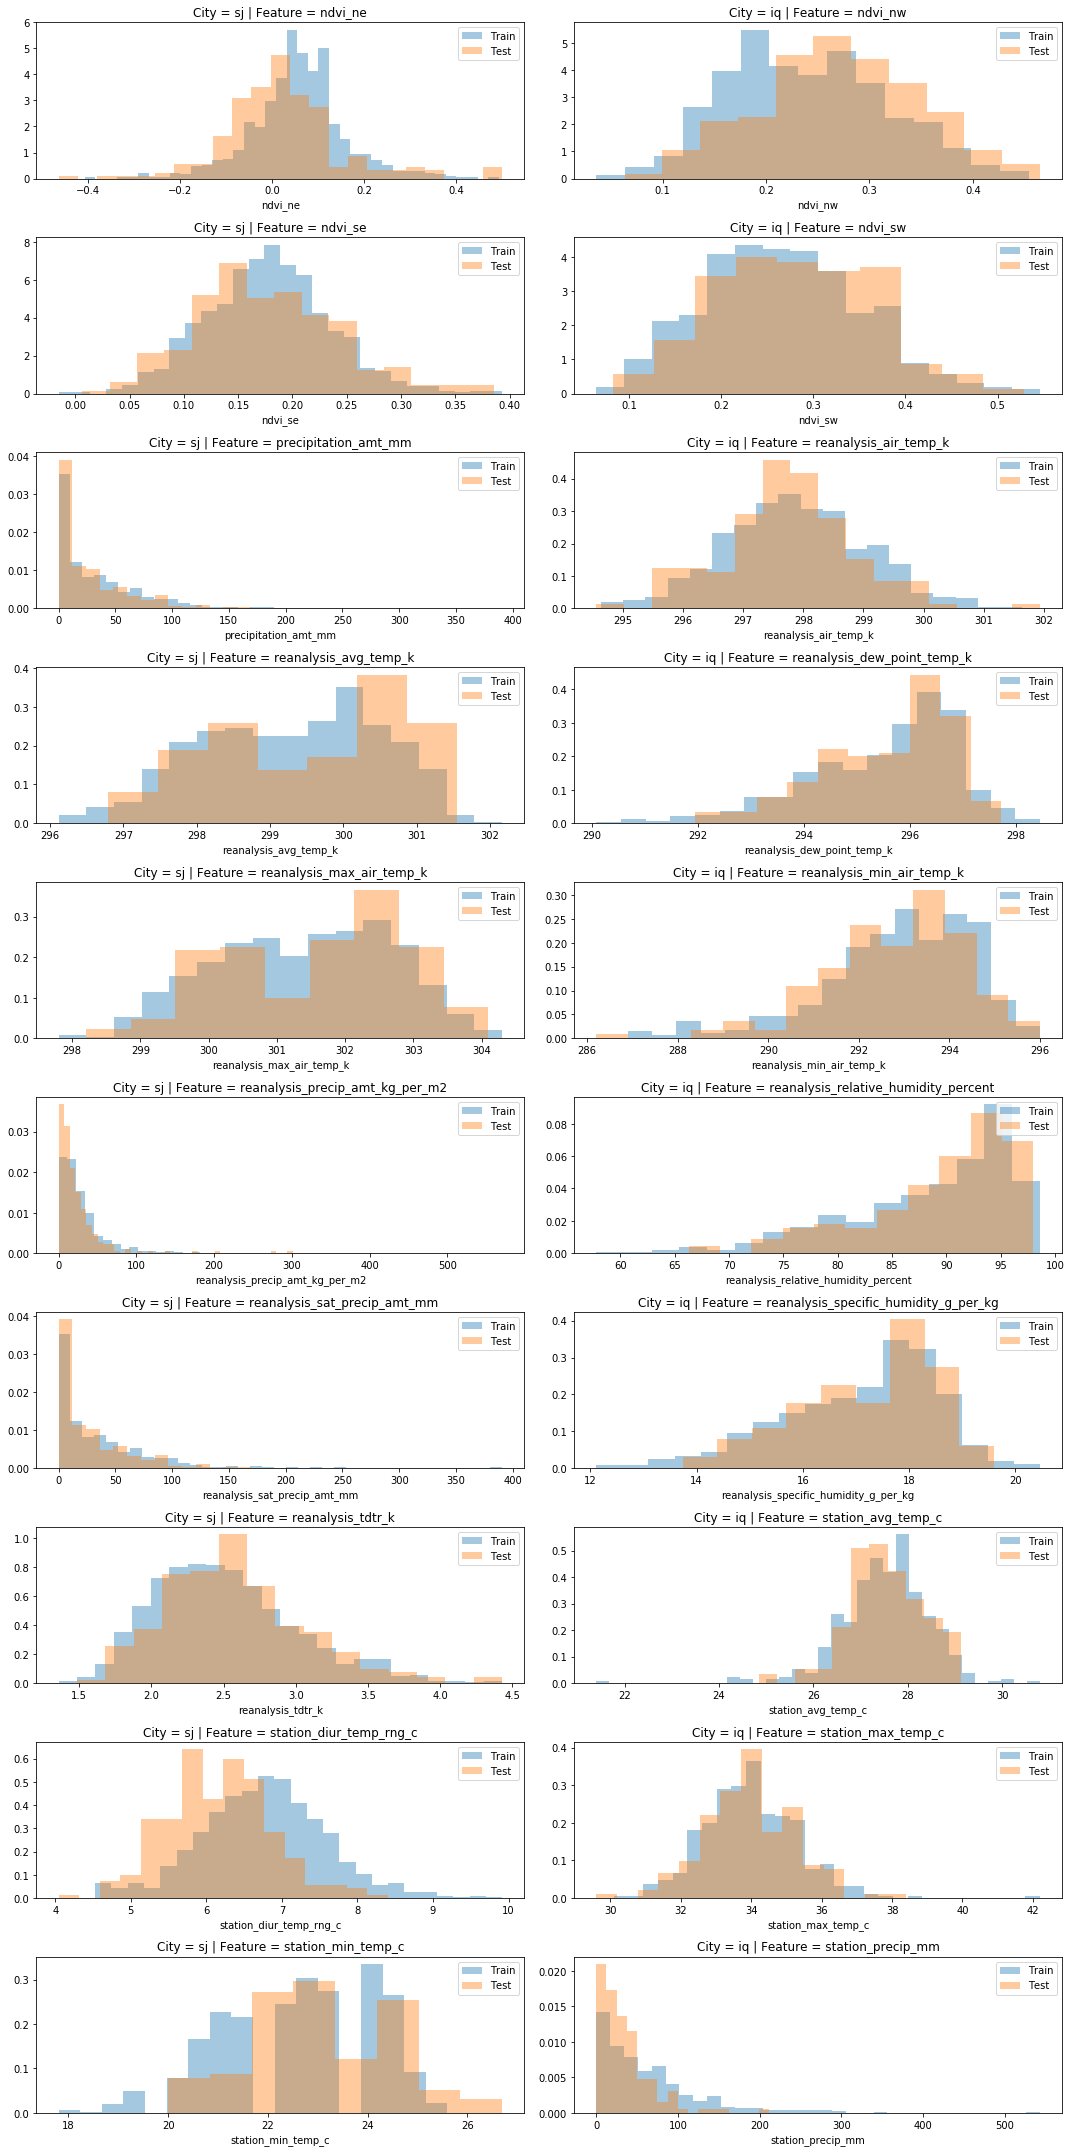

In [13]:
fix, ax = plt.subplots(nrows = 10, ncols = 2, figsize = (15,30))
cities = ['sj', 'iq']
for i, col in enumerate(numeric_cols):
    city = cities[np.mod(i,2)]
    axes = ax[int(np.floor(i/2)),np.mod(i,2)]
    sns.distplot(combined[col][(combined['dataset'] == 'train') & (combined['city'] == city)].dropna(), kde = False, label = 'Train', norm_hist = True, ax = axes)
    sns.distplot(combined[col][(combined['dataset'] == 'test') & (combined['city'] == city)].dropna(), kde = False, label = 'Test', norm_hist = True, ax = axes)
    axes.legend(loc = 'upper right');
    axes.set_title('City = '+  city + ' | Feature = ' + col)
    plt.tight_layout()

To the eye there aren't any features that show significant difference between the training and test set. The ones that appear most different are *nvdi_nw* in iq and *station_diur_temp_rng_c* in sj. 

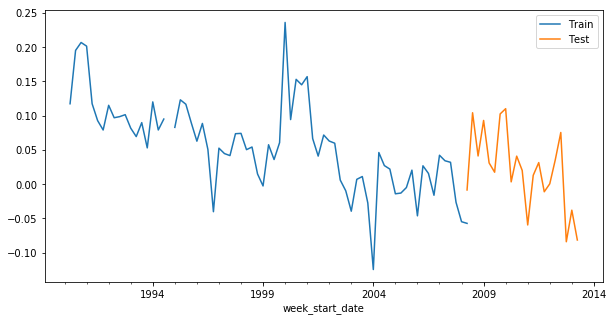

In [53]:
fig, ax = plt.subplots(figsize = (10,5))
train[train['city'] == 'sj'][['week_start_date', 'ndvi_ne']].set_index(pd.DatetimeIndex(train[train['city'] == 'sj']['week_start_date'])).groupby(pd.Grouper(freq='Q')).mean().plot(ax = ax, label = 'Train SJ')
test[test['city'] == 'sj'][['week_start_date', 'ndvi_ne']].set_index(pd.DatetimeIndex(test[test['city'] == 'sj']['week_start_date'])).groupby(pd.Grouper(freq='Q')).mean().plot(ax = ax, label = 'Test SJ')
#ax.legend_.remove()
ax.legend(labels=['Train', 'Test'])

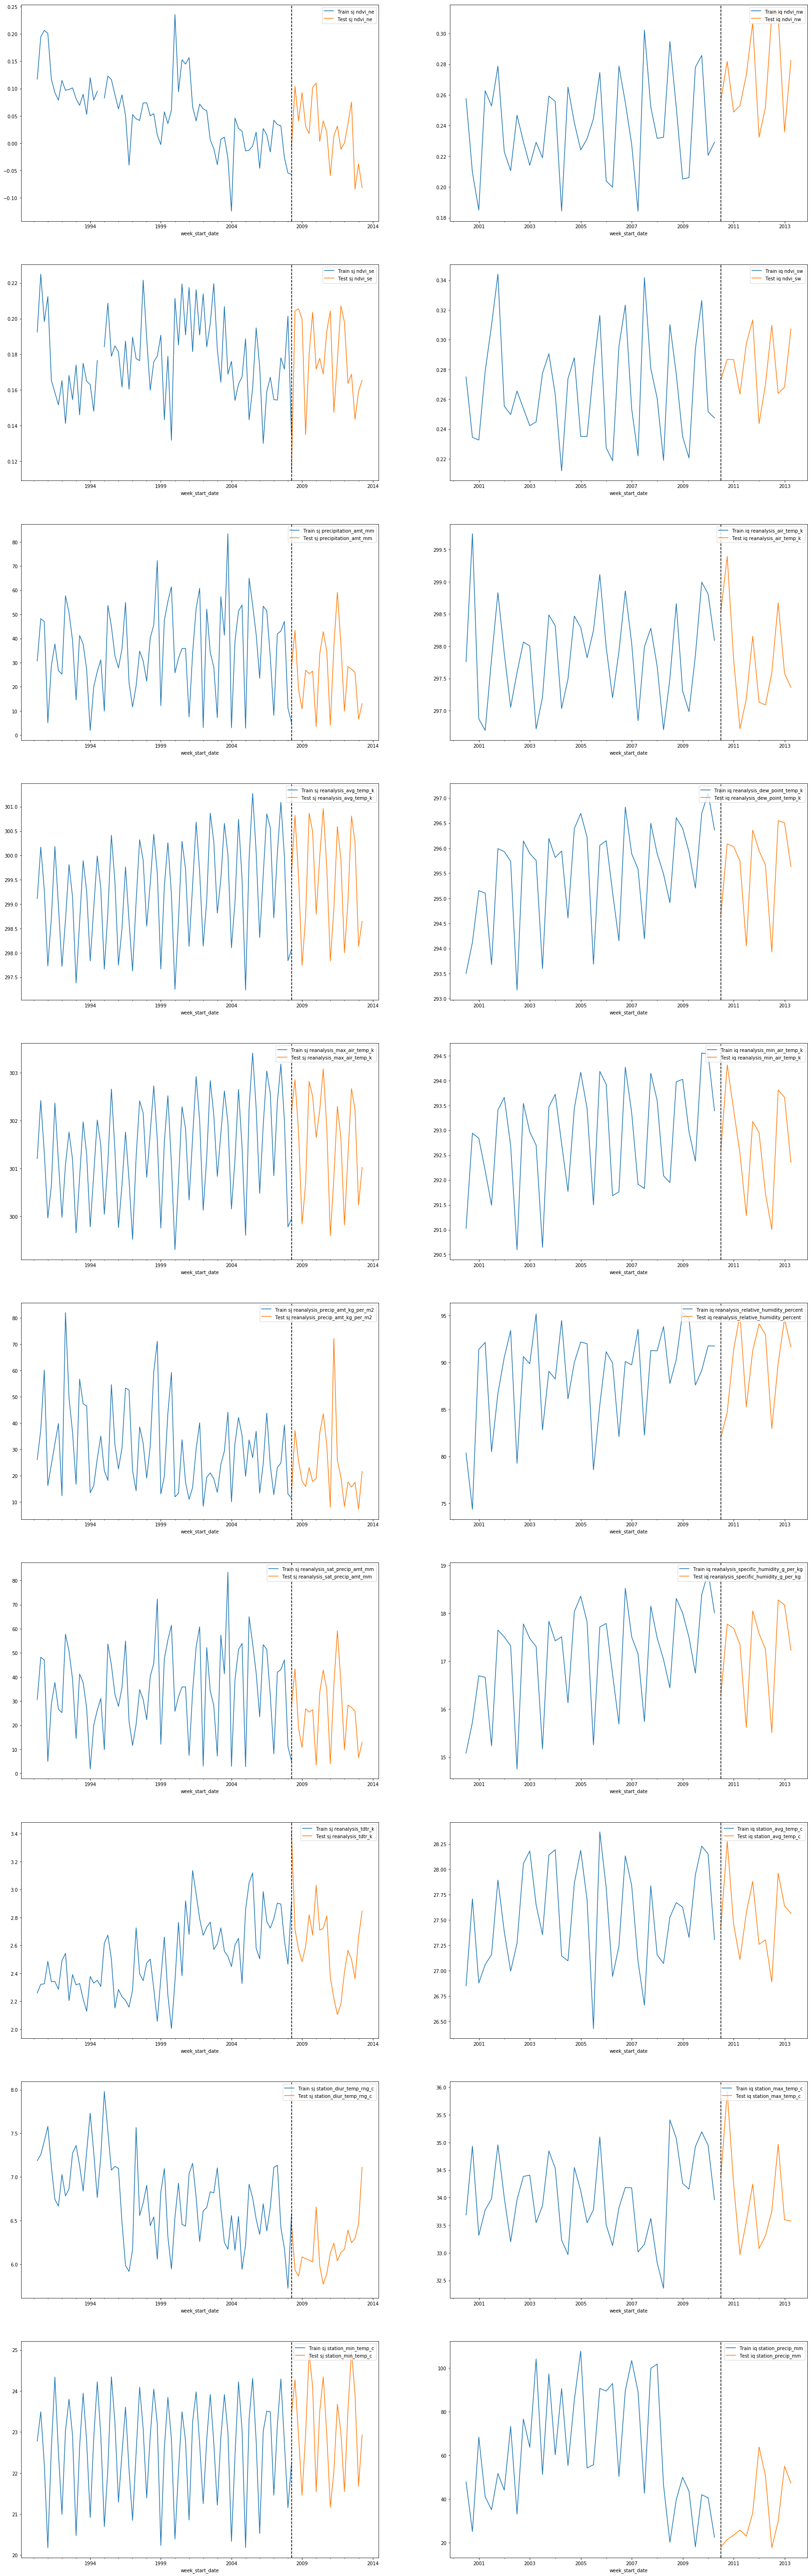

In [100]:
fig, ax = plt.subplots(nrows = 10, ncols = 2, figsize = (30,100))
cities = ['sj', 'iq']
for i, col in enumerate(numeric_cols):
    city = cities[np.mod(i,2)]
    axes = ax[int(np.floor(i/2)),np.mod(i,2)]
    train_test_split_date = np.where(city == 'iq', pd.Timestamp('2010-08-15'), pd.Timestamp('2008-06-30')).tolist()
    train[train['city'] == city][['week_start_date', col]].set_index(pd.DatetimeIndex(train[train['city'] == city]['week_start_date'])).groupby(pd.Grouper(freq='Q')).mean().plot(ax = axes)
    test[test['city'] == city][['week_start_date', col]].set_index(pd.DatetimeIndex(test[test['city'] == city]['week_start_date'])).groupby(pd.Grouper(freq='Q')).mean().plot(ax = axes)
    axes.axvline(train_test_split_date, color = 'black', linestyle = 'dashed')
    axes.legend(labels=['Train ' + city + ' ' + col, 'Test ' + city + ' ' + col], loc = 'upper right')